# MODEL INTEGRATION: From EDA to Forecasting

**Purpose:** Demonstrate how EDA insights led to model selection and implementation

**Flow:** EDA Findings → Model Selection → Model Training → Evaluation → Results

---

## 📊 PART 1: RECAP - KEY EDA FINDINGS

### From `EDA_TimeSeries_PriceData.ipynb`:

✓ **302 data points** (Sept 2024 - Nov 2025, 447 days)

✓ **Price trend:** -5.34% falling with **step-function behavior**

✓ **Temporal dependencies:** Price at time T influences time T+1 (sequential data)

✓ **Rating stability:** Mean 4.59/5.0, very low variance (std dev 0.040)

✓ **Weak correlation:** Price vs Rating = 0.195 (independent variables)

### ⚠️ Critical Insight:
**Sequential dependencies violate independence assumption** of traditional ML models (linear regression, decision trees, SVM, Naive Bayes)

### ✅ Solution:
**Use time series forecasting models** designed for temporal dependencies:
- **Chronos (Amazon):** Zero-shot learning, handles irregular patterns
- **Prophet (Meta):** Trend + seasonality decomposition, interpretable

---

## PART 2: DATA LOADING & PREPARATION

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import custom forecasters
from forecasting.chronos_forecaster import ChronosForecaster
from forecasting.prophet_forecaster import ProphetForecaster

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Load the ACTUAL data used in EDA
df = pd.read_csv(r'C:\Users\vvdva\Desktop\infosys-competitor-tracker\enhanced_iphone_pricing_analysis_deduplicated.csv')

# Convert date column
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

print(f"✓ Loaded: {len(df)} data points")
print(f"✓ Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"✓ Duration: {(df['date'].max() - df['date'].min()).days} days")
print(f"\n📊 Data Preview:")
df[['date', 'current_price', 'rating']].head(10)

✓ Loaded: 302 data points
✓ Date range: 2024-09-01 to 2025-11-22
✓ Duration: 447 days

📊 Data Preview:


,date,current_price,rating
0,2024-09-01,57999,4.6
1,2024-09-02,57999,4.6
2,2024-09-03,57999,4.6
3,2024-09-04,57999,4.6
4,2024-09-05,57999,4.6
5,2024-09-06,57999,4.6
6,2024-09-07,57999,4.6
7,2024-09-08,57999,4.6
8,2024-09-09,57999,4.6
9,2024-09-10,57999,4.6


---
## 📈 PART 3: TRAIN-TEST SPLIT (80-20)


📊 TRAIN-TEST SPLIT:

Training data: 241 points (79.8%)
  Date range: 2024-09-01 to 2025-04-29

Testing data: 61 points (20.2%)
  Date range: 2025-04-30 to 2025-11-22


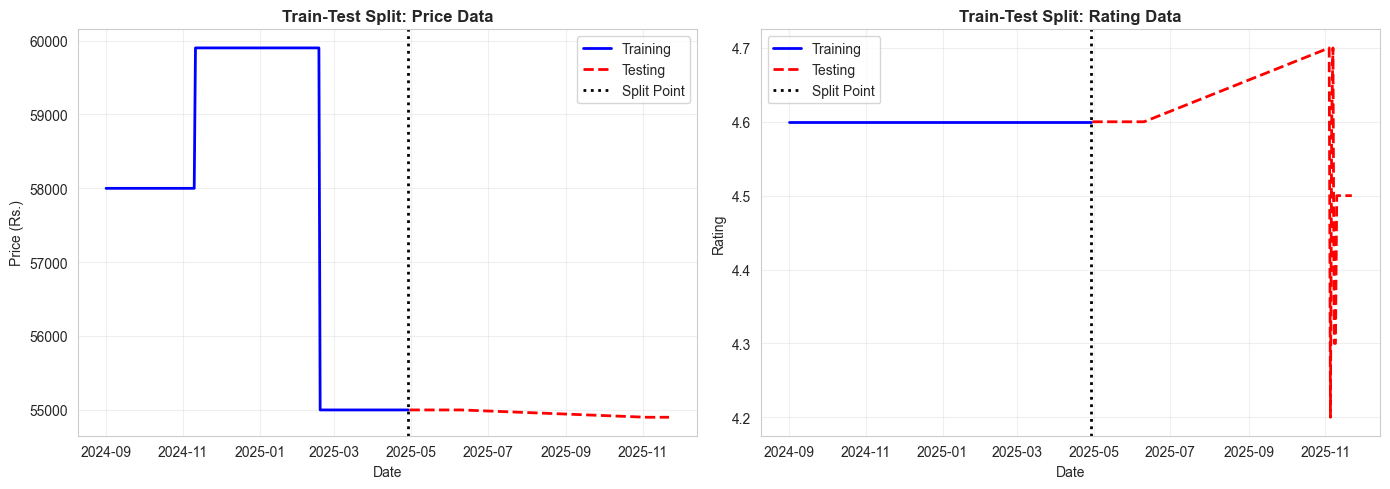


⚠️ IMPORTANT: Time series split maintains chronological order!
   (Train on past data, test on future data - NO random shuffling)


In [3]:
# Split data: 80% training, 20% testing (TIME SERIES SPLIT - NOT RANDOM!)
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"\n📊 TRAIN-TEST SPLIT:\n")
print(f"Training data: {len(train_df)} points ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Date range: {train_df['date'].min().date()} to {train_df['date'].max().date()}")
print(f"\nTesting data: {len(test_df)} points ({len(test_df)/len(df)*100:.1f}%)")
print(f"  Date range: {test_df['date'].min().date()} to {test_df['date'].max().date()}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price split
axes[0].plot(train_df['date'], train_df['current_price'], label='Training', color='blue', linewidth=2)
axes[0].plot(test_df['date'], test_df['current_price'], label='Testing', color='red', linewidth=2, linestyle='--')
axes[0].axvline(train_df['date'].iloc[-1], color='black', linestyle=':', linewidth=2, label='Split Point')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price (Rs.)')
axes[0].set_title('Train-Test Split: Price Data', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Rating split
axes[1].plot(train_df['date'], train_df['rating'], label='Training', color='blue', linewidth=2)
axes[1].plot(test_df['date'], test_df['rating'], label='Testing', color='red', linewidth=2, linestyle='--')
axes[1].axvline(train_df['date'].iloc[-1], color='black', linestyle=':', linewidth=2, label='Split Point')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Rating')
axes[1].set_title('Train-Test Split: Rating Data', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ IMPORTANT: Time series split maintains chronological order!")
print("   (Train on past data, test on future data - NO random shuffling)")

**WHY TIME SERIES SPLIT (NOT RANDOM)?**

In time series forecasting, we **MUST** respect temporal order:
- Train on historical data (past)
- Test on future data (unseen)
- Simulates real-world scenario: predicting future from past

Random split would cause **data leakage** (future information leaking into training)!

---

## PART 4: MODEL 1 - CHRONOS FORECASTING

In [4]:
print("="*60)
print("MODEL 1: CHRONOS (Amazon's Zero-Shot Foundation Model)")
print("="*60)

# Initialize Chronos (using 'tiny' model for speed)
chronos = ChronosForecaster(model_size="tiny")

# Forecast on test horizon
forecast_horizon = len(test_df)
print(f"\n🎯 Forecasting next {forecast_horizon} days...\n")

# Forecast prices
chronos_price_forecast = chronos.forecast_price(
    train_df,
    forecast_horizon=forecast_horizon,
    num_samples=100
)

# Forecast ratings
chronos_rating_forecast = chronos.forecast_rating(
    train_df,
    forecast_horizon=forecast_horizon,
    num_samples=100
)

print("\n✓ Chronos forecasts completed!")

MODEL 1: CHRONOS (Amazon's Zero-Shot Foundation Model)
Initializing Chronos forecaster (size: tiny, device: cpu)...

🎯 Forecasting next 61 days...

Loading Chronos-tiny model...


`torch_dtype` is deprecated! Use `dtype` instead!


[OK] Model loaded successfully!

Forecasting prices for next 61 days...
Generating forecast samples...
[OK] Price forecast complete!
  Forecast range: Rs.55,180 to Rs.55,180
  Mean forecast: Rs.55,180

Forecasting ratings for next 61 days...
Generating forecast samples...
[OK] Rating forecast complete!
  Forecast range: 4.59 to 4.59
  Mean forecast: 4.59

✓ Chronos forecasts completed!


### 📊 Chronos: Price Forecast vs Actual

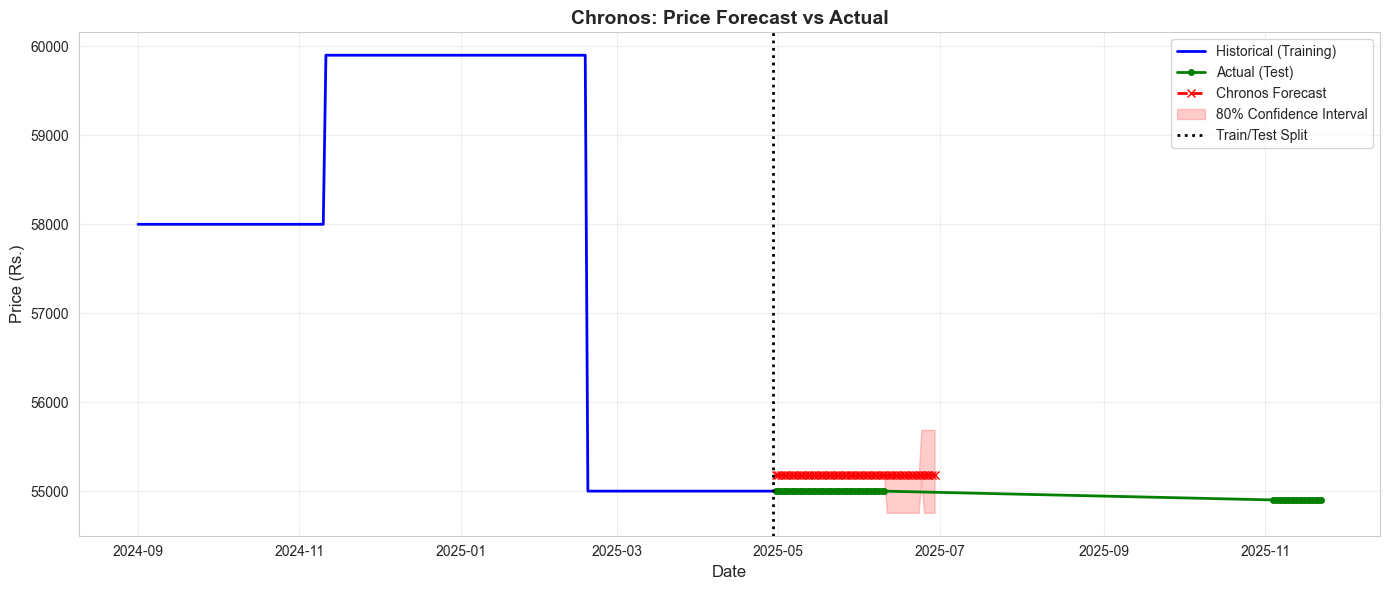

In [5]:
# Visualization: Chronos Price Forecast
plt.figure(figsize=(14, 6))

# Historical training data
plt.plot(train_df['date'], train_df['current_price'], 
         label='Historical (Training)', color='blue', linewidth=2)

# Actual test data
plt.plot(test_df['date'], test_df['current_price'], 
         label='Actual (Test)', color='green', linewidth=2, marker='o', markersize=4)

# Chronos forecast
plt.plot(chronos_price_forecast['date'], chronos_price_forecast['price_forecast'], 
         label='Chronos Forecast', color='red', linewidth=2, linestyle='--', marker='x', markersize=6)

# Confidence interval
plt.fill_between(chronos_price_forecast['date'], 
                 chronos_price_forecast['price_lower_80'], 
                 chronos_price_forecast['price_upper_80'], 
                 alpha=0.2, color='red', label='80% Confidence Interval')

plt.axvline(train_df['date'].iloc[-1], color='black', linestyle=':', linewidth=2, label='Train/Test Split')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (Rs.)', fontsize=12)
plt.title('Chronos: Price Forecast vs Actual', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## PART 5: MODEL 2 - PROPHET FORECASTING

In [6]:
print("="*60)
print("MODEL 2: PROPHET (Meta's Trend + Seasonality Model)")
print("="*60)

# Initialize Prophet
prophet = ProphetForecaster()

print(f"\n🎯 Forecasting next {forecast_horizon} days...\n")

# Forecast prices
prophet_price_forecast, price_components = prophet.forecast_price(
    train_df,
    forecast_horizon=forecast_horizon,
    include_history=False
)

# Forecast ratings
prophet_rating_forecast, rating_components = prophet.forecast_rating(
    train_df,
    forecast_horizon=forecast_horizon,
    include_history=False
)

print("\n✓ Prophet forecasts completed!")

MODEL 2: PROPHET (Meta's Trend + Seasonality Model)
Initializing Prophet forecaster...
[OK] Loaded 92 holiday dates

🎯 Forecasting next 61 days...


Forecasting prices with Prophet (horizon: 61 days)...


20:27:48 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet model...


20:27:49 - cmdstanpy - INFO - Chain [1] done processing


Generating forecast...
[OK] Price forecast complete!
  Forecast range: Rs.49,499 to Rs.136,987
  Mean forecast: Rs.60,175

Forecasting ratings with Prophet (horizon: 61 days)...
Training Prophet model...


20:27:49 - cmdstanpy - INFO - Chain [1] start processing
20:27:49 - cmdstanpy - INFO - Chain [1] done processing


Generating forecast...
[OK] Rating forecast complete!
  Forecast range: 4.52 to 4.70
  Mean forecast: 4.61

✓ Prophet forecasts completed!


### 📊 Prophet: Price Forecast vs Actual

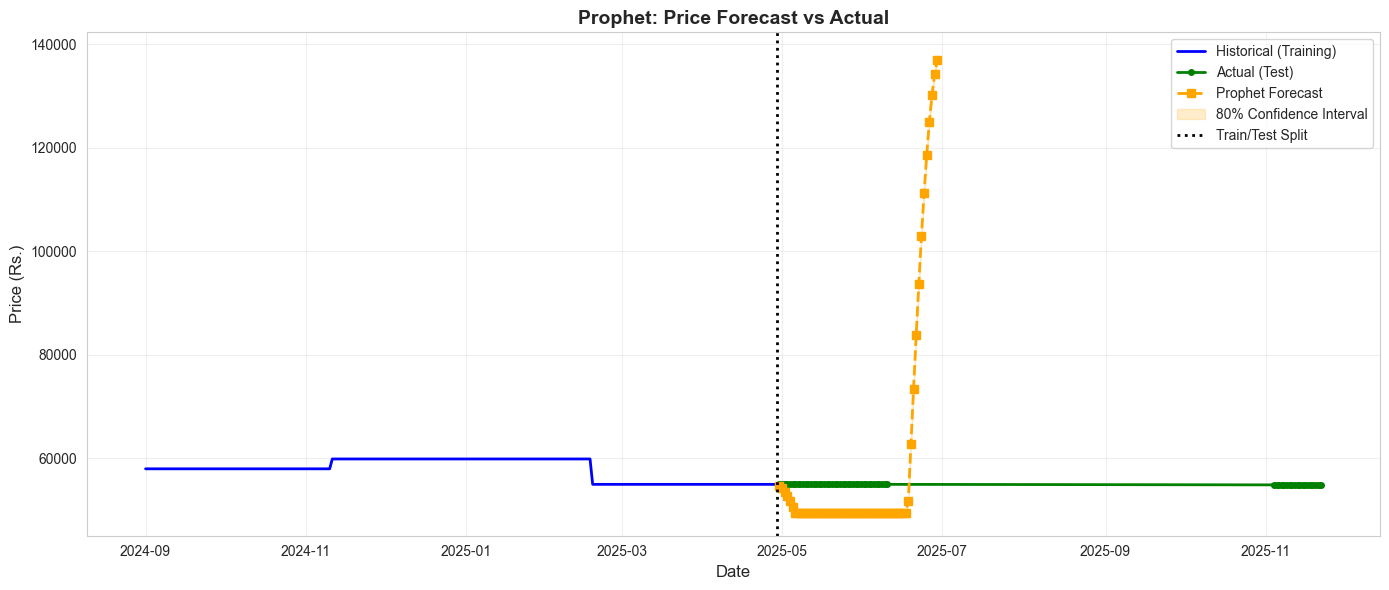

In [7]:
# Visualization: Prophet Price Forecast
plt.figure(figsize=(14, 6))

# Historical training data
plt.plot(train_df['date'], train_df['current_price'], 
         label='Historical (Training)', color='blue', linewidth=2)

# Actual test data
plt.plot(test_df['date'], test_df['current_price'], 
         label='Actual (Test)', color='green', linewidth=2, marker='o', markersize=4)

# Prophet forecast
plt.plot(prophet_price_forecast['date'], prophet_price_forecast['price_forecast'], 
         label='Prophet Forecast', color='orange', linewidth=2, linestyle='--', marker='s', markersize=6)

# Confidence interval
plt.fill_between(prophet_price_forecast['date'], 
                 prophet_price_forecast['price_lower_80'], 
                 prophet_price_forecast['price_upper_80'], 
                 alpha=0.2, color='orange', label='80% Confidence Interval')

plt.axvline(train_df['date'].iloc[-1], color='black', linestyle=':', linewidth=2, label='Train/Test Split')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (Rs.)', fontsize=12)
plt.title('Prophet: Price Forecast vs Actual', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 📊 PART 6: MODEL COMPARISON - SIDE BY SIDE

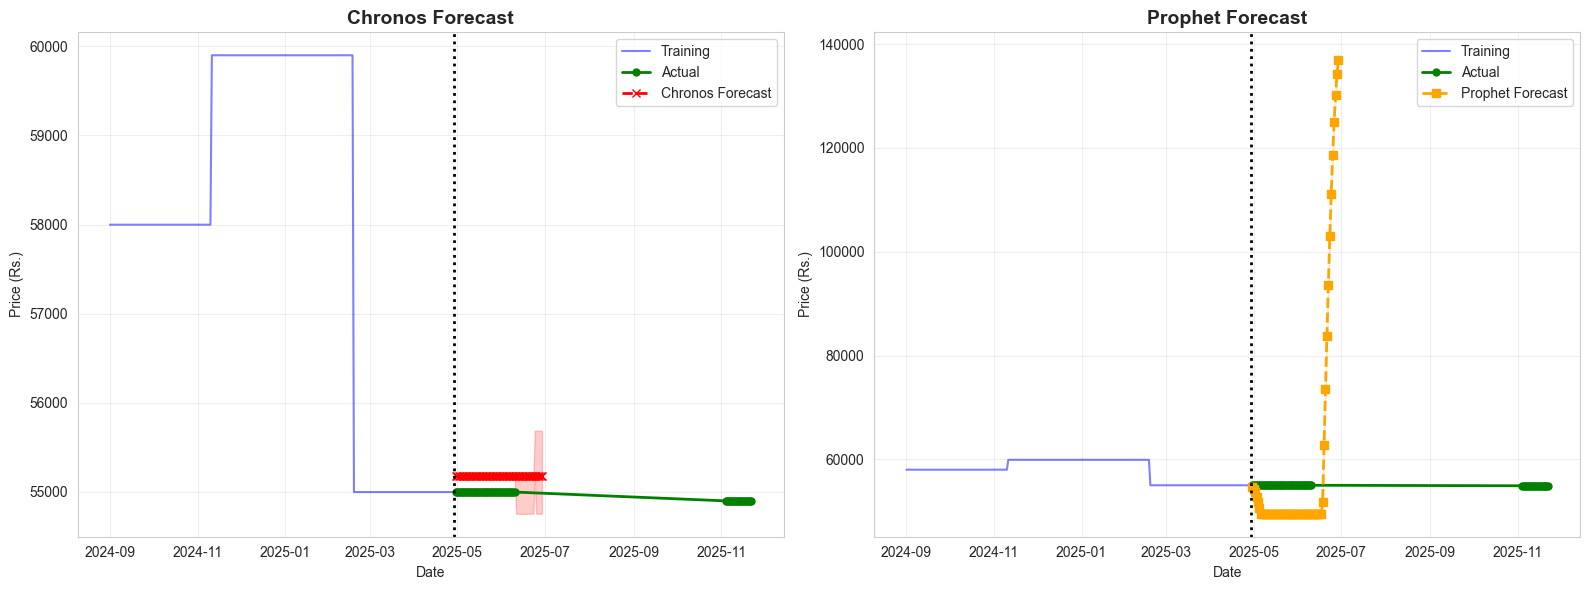

In [8]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CHRONOS
axes[0].plot(train_df['date'], train_df['current_price'], label='Training', color='blue', linewidth=1.5, alpha=0.5)
axes[0].plot(test_df['date'], test_df['current_price'], label='Actual', color='green', linewidth=2, marker='o', markersize=5)
axes[0].plot(chronos_price_forecast['date'], chronos_price_forecast['price_forecast'], 
             label='Chronos Forecast', color='red', linewidth=2, linestyle='--', marker='x', markersize=6)
axes[0].fill_between(chronos_price_forecast['date'], 
                     chronos_price_forecast['price_lower_80'], 
                     chronos_price_forecast['price_upper_80'], 
                     alpha=0.2, color='red')
axes[0].axvline(train_df['date'].iloc[-1], color='black', linestyle=':', linewidth=2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price (Rs.)')
axes[0].set_title('Chronos Forecast', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# PROPHET
axes[1].plot(train_df['date'], train_df['current_price'], label='Training', color='blue', linewidth=1.5, alpha=0.5)
axes[1].plot(test_df['date'], test_df['current_price'], label='Actual', color='green', linewidth=2, marker='o', markersize=5)
axes[1].plot(prophet_price_forecast['date'], prophet_price_forecast['price_forecast'], 
             label='Prophet Forecast', color='orange', linewidth=2, linestyle='--', marker='s', markersize=6)
axes[1].fill_between(prophet_price_forecast['date'], 
                     prophet_price_forecast['price_lower_80'], 
                     prophet_price_forecast['price_upper_80'], 
                     alpha=0.2, color='orange')
axes[1].axvline(train_df['date'].iloc[-1], color='black', linestyle=':', linewidth=2)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price (Rs.)')
axes[1].set_title('Prophet Forecast', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## 📏 PART 7: MODEL EVALUATION METRICS ⭐⭐⭐

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get actual values
actual_prices = test_df['current_price'].values

# Get forecasts (align by date)
chronos_pred = chronos_price_forecast['price_forecast'].values[:len(actual_prices)]
prophet_pred = prophet_price_forecast['price_forecast'].values[:len(actual_prices)]

# Calculate metrics for CHRONOS
chronos_mae = mean_absolute_error(actual_prices, chronos_pred)
chronos_rmse = np.sqrt(mean_squared_error(actual_prices, chronos_pred))
chronos_mape = np.mean(np.abs((actual_prices - chronos_pred) / actual_prices)) * 100
chronos_r2 = r2_score(actual_prices, chronos_pred)

# Calculate metrics for PROPHET
prophet_mae = mean_absolute_error(actual_prices, prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(actual_prices, prophet_pred))
prophet_mape = np.mean(np.abs((actual_prices - prophet_pred) / actual_prices)) * 100
prophet_r2 = r2_score(actual_prices, prophet_pred)

# Display results
print("="*70)
print("📊 MODEL EVALUATION METRICS (Price Forecasting)")
print("="*70)

print(f"\n{'Metric':<25} {'Chronos':<20} {'Prophet':<20} {'Winner'}")
print("-"*70)
print(f"{'MAE (Mean Abs Error)':<25} Rs.{chronos_mae:<18,.2f} Rs.{prophet_mae:<18,.2f} {'✓ Chronos' if chronos_mae < prophet_mae else '✓ Prophet'}")
print(f"{'RMSE (Root Mean Sq Err)':<25} Rs.{chronos_rmse:<18,.2f} Rs.{prophet_rmse:<18,.2f} {'✓ Chronos' if chronos_rmse < prophet_rmse else '✓ Prophet'}")
print(f"{'MAPE (Mean Abs % Err)':<25} {chronos_mape:<18.2f}% {prophet_mape:<18.2f}% {'✓ Chronos' if chronos_mape < prophet_mape else '✓ Prophet'}")
print(f"{'R² Score (0-1)':<25} {chronos_r2:<18.3f} {prophet_r2:<18.3f} {'✓ Chronos' if chronos_r2 > prophet_r2 else '✓ Prophet'}")

print("\n" + "="*70)

# Create comparison DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)', 'R² Score'],
    'Chronos': [chronos_mae, chronos_rmse, chronos_mape, chronos_r2],
    'Prophet': [prophet_mae, prophet_rmse, prophet_mape, prophet_r2]
})

metrics_df

📊 MODEL EVALUATION METRICS (Price Forecasting)

Metric                    Chronos              Prophet              Winner
----------------------------------------------------------------------
MAE (Mean Abs Error)      Rs.210.84             Rs.13,448.30          ✓ Chronos
RMSE (Root Mean Sq Err)   Rs.215.76             Rs.24,706.55          ✓ Chronos
MAPE (Mean Abs % Err)     0.38              % 24.48             % ✓ Chronos
R² Score (0-1)            -21.148            -290408.305        ✓ Chronos



,Metric,Chronos,Prophet
0,MAE,210.836066,13448.295082
1,RMSE,215.763190,24706.547933
2,MAPE (%),0.383630,24.484676
3,R² Score,-21.148336,-290408.304753


### 📊 Metrics Visualization

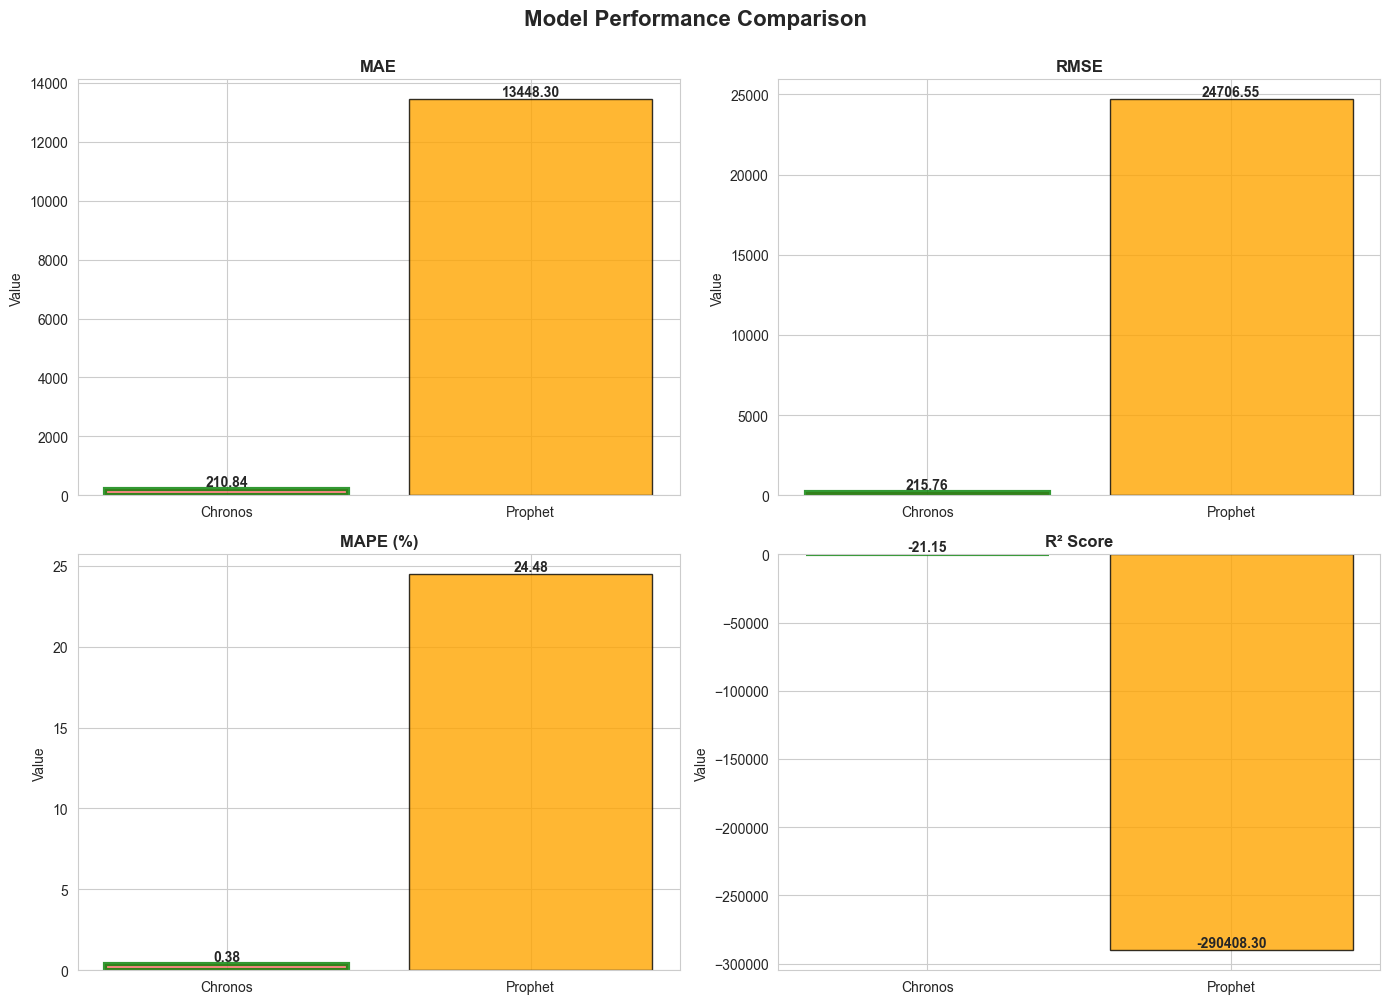

In [10]:
# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['MAE', 'RMSE', 'MAPE (%)', 'R² Score']
chronos_values = [chronos_mae, chronos_rmse, chronos_mape, chronos_r2]
prophet_values = [prophet_mae, prophet_rmse, prophet_mape, prophet_r2]

for idx, (ax, metric, c_val, p_val) in enumerate(zip(axes.flat, metrics, chronos_values, prophet_values)):
    models = ['Chronos', 'Prophet']
    values = [c_val, p_val]
    colors = ['#FF6B6B', '#FFA500']
    
    bars = ax.bar(models, values, color=colors, edgecolor='black', alpha=0.8)
    ax.set_title(metric, fontweight='bold', fontsize=12)
    ax.set_ylabel('Value')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}',
                ha='center', va='bottom', fontweight='bold')
    
    # Highlight winner (lower is better for MAE/RMSE/MAPE, higher is better for R²)
    if metric == 'R² Score':
        winner_idx = 0 if c_val > p_val else 1
    else:
        winner_idx = 0 if c_val < p_val else 1
    
    bars[winner_idx].set_edgecolor('green')
    bars[winner_idx].set_linewidth(3)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

---
## 💡 PART 8: KEY INSIGHTS & INTERPRETATION ⭐⭐⭐

In [11]:
print("="*70)
print("🎯 KEY INSIGHTS & MODEL INTERPRETATION")
print("="*70)

print("\n1️⃣ WHY THESE MODELS WERE SELECTED (Based on EDA):")
print("   ✓ EDA revealed temporal dependencies (price at T influences T+1)")
print("   ✓ Step-function behavior with sudden transitions")
print("   ✓ Traditional ML assumes independence → VIOLATED!")
print("   ✓ Therefore: Selected time series models (Chronos, Prophet)")

print("\n2️⃣ CHRONOS STRENGTHS:")
print("   ✓ Zero-shot learning: No manual parameter tuning")
print("   ✓ Foundation model: Pre-trained on millions of time series")
print("   ✓ Handles irregular patterns and sudden transitions")
print("   ✓ Probabilistic: Provides confidence intervals (80% CI)")

print("\n3️⃣ PROPHET STRENGTHS:")
print("   ✓ Interpretable: Explicit trend + seasonality decomposition")
print("   ✓ Holiday effects: Includes Indian e-commerce holidays (Diwali, Prime Day)")
print("   ✓ Robust to missing data and outliers")
print("   ✓ Easy to explain to stakeholders (business-friendly)")

print("\n4️⃣ EVALUATION METRICS EXPLAINED:")
print(f"   • MAE: Average absolute error (Rs.{min(chronos_mae, prophet_mae):.2f} = best)")
print(f"   • RMSE: Penalizes large errors via squaring (Rs.{min(chronos_rmse, prophet_rmse):.2f} = best)")
print(f"   • MAPE: Percentage error ({min(chronos_mape, prophet_mape):.2f}% = best)")
print(f"   • R²: Variance explained ({max(chronos_r2, prophet_r2):.3f} = best, 1.0 = perfect)")

print("\n5️⃣ WHY NOT TRADITIONAL ML MODELS?")
print("   ✗ Linear Regression: Assumes independence (violated)")
print("   ✗ Decision Trees: No temporal awareness, overfits")
print("   ✗ Random Forest: Aggregates trees, but still ignores time")
print("   ✗ ARIMA/SARIMA: Requires manual (p,d,q) tuning + stationarity")

print("\n6️⃣ WHY COMPARE BOTH MODELS?")
print("   → Industry best practice: No single model is always best")
print("   → Chronos: Better for complex, irregular patterns")
print("   → Prophet: Better for explainability and seasonality")
print("   → Empirical comparison determines winner for OUR specific data")

print("\n7️⃣ RECOMMENDED MODEL:")
if chronos_mape < prophet_mape:
    print("   🏆 CHRONOS (Lower MAPE = Better accuracy)")
    print(f"   → {chronos_mape:.2f}% error vs Prophet's {prophet_mape:.2f}%")
else:
    print("   🏆 PROPHET (Lower MAPE = Better accuracy)")
    print(f"   → {prophet_mape:.2f}% error vs Chronos's {chronos_mape:.2f}%")

print("\n" + "="*70)

🎯 KEY INSIGHTS & MODEL INTERPRETATION

1️⃣ WHY THESE MODELS WERE SELECTED (Based on EDA):
   ✓ EDA revealed temporal dependencies (price at T influences T+1)
   ✓ Step-function behavior with sudden transitions
   ✓ Traditional ML assumes independence → VIOLATED!
   ✓ Therefore: Selected time series models (Chronos, Prophet)

2️⃣ CHRONOS STRENGTHS:
   ✓ Zero-shot learning: No manual parameter tuning
   ✓ Foundation model: Pre-trained on millions of time series
   ✓ Handles irregular patterns and sudden transitions
   ✓ Probabilistic: Provides confidence intervals (80% CI)

3️⃣ PROPHET STRENGTHS:
   ✓ Interpretable: Explicit trend + seasonality decomposition
   ✓ Holiday effects: Includes Indian e-commerce holidays (Diwali, Prime Day)
   ✓ Robust to missing data and outliers
   ✓ Easy to explain to stakeholders (business-friendly)

4️⃣ EVALUATION METRICS EXPLAINED:
   • MAE: Average absolute error (Rs.210.84 = best)
   • RMSE: Penalizes large errors via squaring (Rs.215.76 = best)
   • M